# Create DRNN (Deep Recurrent Neural Network)  Models using MZModel

This example shows you how to use the `dlpy.mzmodel` subpackage to create a DRNN model to perform object detection. The `dlpy.mzmodel` subpackage leverages the [SAS Deep Learning Model Zoo](https://go.documentation.sas.com/doc/en/pgmsascdc/latest/casdlmzpg/titlepage.htm) utilities to manage deep learning models on the CAS server.

## Table of Contents
1. [Set Up Environment](#setup)
2. [Load Data](#prepare)
3. [Build the Model](#build)
4. [Train the Model](#train)
5. [Score the Model and Visualize Scoring Results](#score)

## Set Up Environment <a id="setup"><a>

First, import the various Python and SAS DLPy packages that will be used in this notebook session. Begin by importing the SAS Statistical Wrapper for Analytic Transactions (SWAT). SWAT is the Python interface to SAS CAS. Here is more information about [starting a SAS CAS session with the SWAT package](https://sassoftware.github.io/python-swat/getting-started.html).

In [1]:
import swat as sw
import sys
from dlpy.mzmodel import *
from dlpy.utils import *
from dlpy.splitting import two_way_split

Create a CAS session instance. Provide connection information to your running CAS server. For this example, assume the CAS server is hosted at `cloud.example.com` on port `5570`.

In [2]:
# Connect to an existing CAS server
s = sw.CAS('cloud.example.com',5570)

## Load Data <a id="prepare"></a>

In [3]:
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='dnfs',
                  path='/path/to/data',
                  subdirectories=True)

NOTE: Cloud Analytic Services added the caslib 'dnfs'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient,TableRedistUpPolicy
0,dnfs,PATH,,/path/to/data/,,1.0,1.0,0.0,0.0,0.0,0.0,Not Specified


In [4]:
s.setsessopt(caslib='dnfs')

NOTE: 'dnfs' is now the active caslib.


+ Elapsed: 0.000577s, user: 0.000501s, mem: 0.273mb

In [5]:
s.table.loadTable(caslib='dnfs', 
                  path='dlx_data/fashion_mnist_valid.sashdat', 
                  casout = dict(name = 'cas_table', blocksize = '1', replace = True)) 
data = s.CASTable('cas_table')

NOTE: Cloud Analytic Services made the file dlx_data/fashion_mnist_valid.sashdat available as table CAS_TABLE in caslib dnfs.


Use the `two_way_split()` function to partition the contents of the data. Setting the test_rate parameter to 15% means that 85% of the images are allocated to the new train role table named train_data, and the remaining 15% images are allocated to the new test role table named test_data.

In [6]:
train_data, test_data = two_way_split(data, 
                                      stratify_by='xlabels',
                                      test_rate=15, 
                                      seed=12345
                                      )

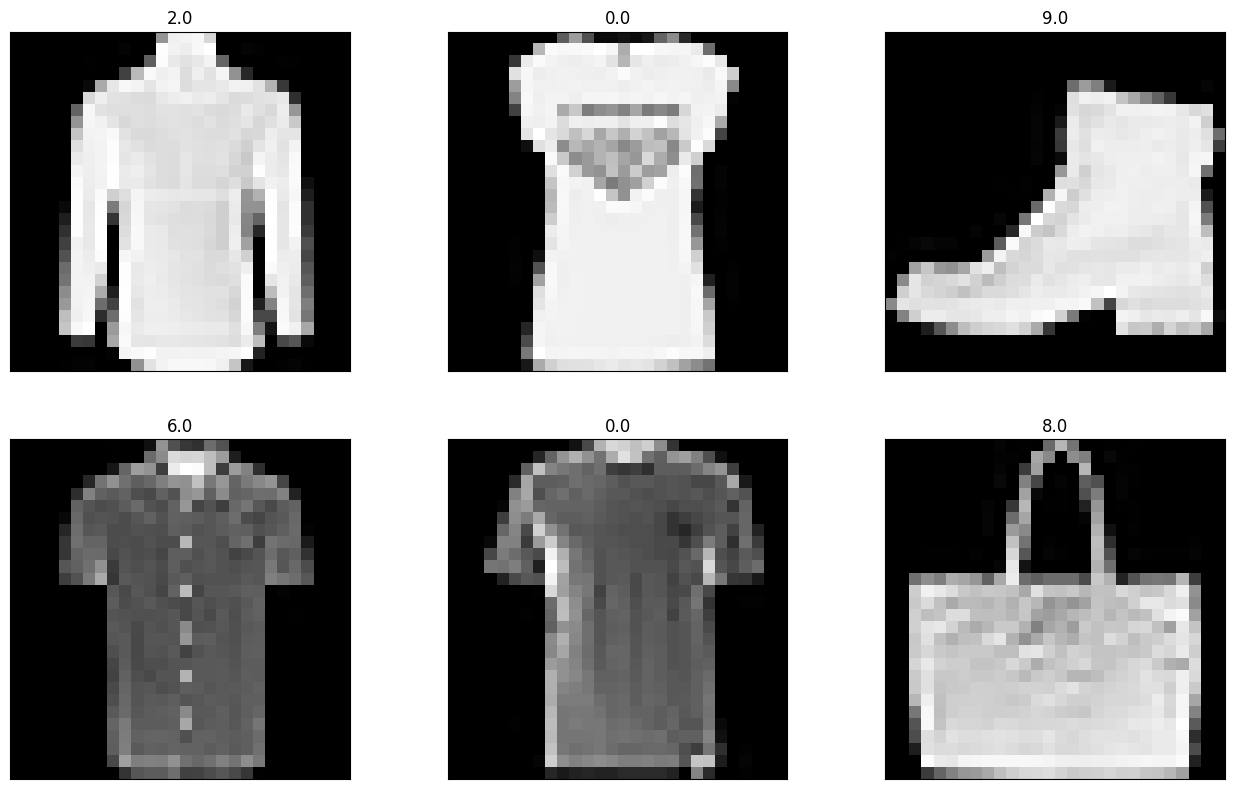

In [7]:
train_data.show(6, ncol=3, randomize=True)

The new data now contains the following columns

In [8]:
train_data.fetch(to=5)

NOTE: Varbinary column '_image_' may not be in a format that can be displayed consistently.


,_image_,_label_,_filename_0,_id_
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,3.0,3_2364719987.jpg,3204
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,9.0,9_1689391660.jpg,1146
2,"b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...",3.0,3_6161136371.jpg,1682
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.0,0_5066915620.jpg,8914
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.0,0_6448778776.jpg,8292


## Build the Model <a id="build"></a>

Create a DRNN model by using the `MZModel()` constructor. Because `DRNN` is available in the Deep Learning Model Zoo, you can specify the architecture by using `type="torchNative"` and `name="drnn"`, along with hyper-parameters such as `hidden_size`, `num_layers` and `rnn_type`. Fit the model to the data set by specifying `num_classes=10` to account for the 10 classes in the data set. If you have a set of weights for the architecture, you can begin training from that set of weights by setting the model_path to the path of the file that contains the weights.

In [9]:
model = MZModel(conn=s, model_type="torchNative", model_name="DRNN", num_classes=10, 
                input_size=32, hidden_size=20, num_layers=2, rnn_type="RNN",
                model_path="/path/to/model/drnn_classifier_model.pt")

The `add_image_transformation()` method enables you to add an image transformation step to resize the image.

In [10]:
model.add_image_transformation(image_size='32 32')

# Train the Model <a id="train"></a>

Use the `train()` method of the `MZModel` class to train the DRNN model. Use `inputs` to specify the column that contains the images and `targets` to specify the column that containst the labels. Pass your optimizer and gpu settings.

In [12]:
optimizer=Optimizer(seed=54321, 
                    algorithm=AdamSolver(lr=0.001),
                    batch_size=64,
                    max_epochs=15                   
                    )

In [13]:
model.train(table=train_data, inputs="_image_", targets="_label_", gpu=[0], optimizer=optimizer)

NOTE: 
---------- Starting the dlmzTrain Action ----------
NOTE: No target map from nominal values to numeric values is found.
NOTE: Using this GPU List on your-server.unx.company.com: [0 ].
NOTE: Worker rank 0: your-server.unx.company.com, using up to 1 GPU devices.
NOTE: Using your-server.unx.company.com: GPU 0 processes up to 64 records at a time.
NOTE: Starting dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 1638343 device= GPU:0
NOTE: Learning Rate:   0.001 Beta1:     0.9 Beta2:   0.999 BatchSize: 64 Rank: 0 Device: 0 Loss: 5954.27
NOTE: The action completed successfully.


,Epoch,Loss,MCE
0,0.0,15263.051973,0.778034
1,1.0,11417.522814,0.670894
2,2.0,9900.699067,0.610752
3,3.0,9066.739768,0.562283
4,4.0,8302.345165,0.513570
5,5.0,7595.550972,0.479219
6,6.0,7101.437878,0.459067
7,7.0,6732.692836,0.442814
8,8.0,6516.311059,0.439952
9,9.0,6341.278735,0.433475


## Score the Model and Visualize Scoring Results <a id="score"></a>

Use the `MZModel.score()` method to score the data.

In [14]:
model.score(table=test_data, inputs="_image_", targets="_label_", gpu=[0], batch_size=64, copy_vars=["_image_", "_label_"])

NOTE: 
---------- Starting the dlmzScore Action ----------
NOTE: Using this GPU List on your-server.unx.company.com: [0 ].
NOTE: No target map from nominal values to numeric values is found.
NOTE: In the score output, expected nominal values will be in raw numeric representation.
NOTE: The specified YAML option string overrides the one saved in the model table.
NOTE: Worker rank 0: your-server.unx.company.com, using up to 1 GPU devices.
NOTE: Using your-server.unx.company.com: GPU 0 processes up to 64 records at a time.
NOTE: Using existing dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 1638343 device= GPU:0
NOTE: The action completed successfully.


,Loss,MCE
0,1079.224677,0.423158


In the score output table, each row corresponds to an image, followed by the ground truth class, and predicted class.

In [15]:
model.table_out.fetch()

NOTE: Varbinary column '_image_' may not be in a format that can be displayed consistently.


,_image_,_label_,_predClass_
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,1.0,1
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2.0,2
2,"b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...",9.0,9
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,3.0,0
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,7.0,7
5,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,6.0,0
6,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0.0,3
7,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,5.0,5
8,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,5.0,5
9,"b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...",5.0,5
